# Imputacion basada en Modelos

## Preparacion del entorno

### Librerias

In [1]:
import janitor  # limpiar datos
import matplotlib.pyplot as plt # visualizacion de datos
import missingno    # exploracion de valores faltantes
import nhanes.load  # libreria con los datos a analizar
import numpy as np  # calculos numericos
import pandas as pd # trabajar con dataframe
import scipy.stats  # trabjar con estadisticos
import seaborn as sns   #   visualizacion estadistica
# import session_info
# sklearn contiene los modelos a utilizar
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Configuracion de Graficas

In [2]:
%matplotlib inline

# tamaño de los graficos
sns.set(
    rc={
        'figure.figsize':(8, 6)
    }
)

# estilo de los graficos
sns.set_style('whitegrid')

### Importar funciones personalizadas

In [3]:
%run '../utils2.ipynb'

## Cargar datos preparados

In [4]:
%run tratamiento_v_categoricas.ipynb

12.25 %


## Imputacion para Cigarettes vs Sugar_gm

### Procesar datos

In [17]:
# sustituimos los valores faltantes de una variable de interes con dummies
# admite dos varibles con missing y dos varibles completas

nhanes_model_df = (
    nhanes_transformed_df
    # dos variables categoricas, dos numericas
    .select_columns('sugar_gm', 'cigarettes', 'weight', 'diabetes')
    .sort_values('sugar_gm') # ordenamos en funcion de sugar_gm. variable de interes
    # sustituir missing de cigarettes con dummies
    .transform_column(
        'cigarettes', # variable con dummies
        lambda x: x.bfill(),
        elementwise=False
    )
    .transform_column(
        'cigarettes',
        lambda x: x.ffill(),
        elementwise=False
    )
    # matriz de sombra para las variables seleccionadas
    .missing.bind_shadow_matrix2(
        True,
        False,
        suffix='_imp',
        only_missing=False
    )
)

nhanes_model_df

,sugar_gm,cigarettes,weight,diabetes,sugar_gm_imp,cigarettes_imp,weight_imp,diabetes_imp
SEQN,,,,,,,,
94342.0,5.397605e-79,1.0,192.0,0.0,False,False,False,False
99702.0,5.397605e-79,1.0,150.0,0.0,False,False,False,False
95641.0,5.397605e-79,0.0,298.0,1.0,False,False,False,False
97729.0,1.900000e-01,1.0,190.0,0.0,False,False,False,False
97483.0,2.200000e-01,1.0,245.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102943.0,NaN,1.0,276.0,0.0,True,False,False,False
102946.0,NaN,1.0,180.0,1.0,True,False,False,False
102948.0,NaN,1.0,118.0,0.0,True,False,False,False


### Preparacion del Modelo

In [20]:
# utilizamos la regresion lineal como modelo

sugar_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols('sugar_gm ~ weight + cigarettes + diabetes', data=df)
    )
    .fit()
)

### Generacion de los valores imputados mediante el modelo

In [19]:
# obtener las observaciones con valores nulos en la variable de ordenacion (sugar_gm)

(
    nhanes_model_df
    .pipe(
        lambda df: df[df.sugar_gm.isna()]
    )
)

,sugar_gm,cigarettes,weight,diabetes,sugar_gm_imp,cigarettes_imp,weight_imp,diabetes_imp
SEQN,,,,,,,,
93706.0,NaN,0.0,145.0,0.0,True,False,False,False
93709.0,NaN,0.0,200.0,0.0,True,False,False,False
93718.0,NaN,0.0,140.0,0.0,True,False,False,False
93730.0,NaN,0.0,180.0,1.0,True,False,False,False
93761.0,NaN,0.0,181.0,0.0,True,False,False,False
...,...,...,...,...,...,...,...,...
102943.0,NaN,1.0,276.0,0.0,True,False,False,False
102946.0,NaN,1.0,180.0,1.0,True,False,False,False
102948.0,NaN,1.0,118.0,0.0,True,False,False,False


In [23]:
# utilizamos el modelo para generar los valores imputados de sugar_gm

ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.sugar_gm.isna()]
    )
    .pipe(
        lambda df: sugar_ols.predict(df).round(2)
    )
) 

ols_imputed_values

SEQN
93706.0     106.33
93709.0     106.35
93718.0     106.33
93730.0      90.52
93761.0     106.34
             ...  
102943.0     94.71
102946.0     78.85
102948.0     94.65
102949.0    106.34
102953.0     94.69
Length: 1213, dtype: float64

### Sustitucion de los valores imputados en el dataset

In [24]:
nhanes_model_df.loc[nhanes_model_df.sugar_gm.isna(), ['sugar_gm']] = ols_imputed_values

nhanes_model_df

,sugar_gm,cigarettes,weight,diabetes,sugar_gm_imp,cigarettes_imp,weight_imp,diabetes_imp
SEQN,,,,,,,,
94342.0,5.397605e-79,1.0,192.0,0.0,False,False,False,False
99702.0,5.397605e-79,1.0,150.0,0.0,False,False,False,False
95641.0,5.397605e-79,0.0,298.0,1.0,False,False,False,False
97729.0,1.900000e-01,1.0,190.0,0.0,False,False,False,False
97483.0,2.200000e-01,1.0,245.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102943.0,9.471000e+01,1.0,276.0,0.0,True,False,False,False
102946.0,7.885000e+01,1.0,180.0,1.0,True,False,False,False
102948.0,9.465000e+01,1.0,118.0,0.0,True,False,False,False


### Visualizacion de los valores imputados

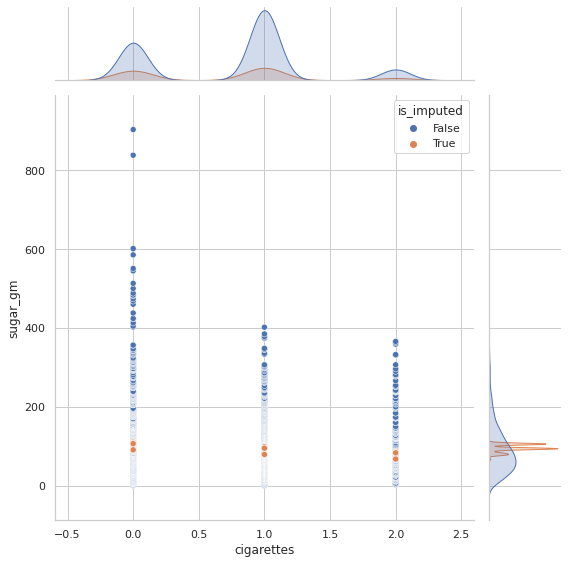

In [26]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x = 'cigarettes',
        y = 'sugar_gm',
        show_marginal = True,   # muestra la distribucion a los costado
        height = 8             # tamano del grafico
    )
)

In [27]:
print('''Para esta grafica observamos una buena imputacion para cigarettes pero para la variable de
interes sugar_gm los valores imputados se concentran en ciertos valores lo cual indica que es una
mala imputacion''')

Para esta grafica observamos una buena imputacion para cigarettes pero para la variable de
interes sugar_gm los valores imputados se concentran en ciertos valores lo cual indica que es una
mala imputacion
